In [1]:
from pathlib import Path
import pandas as pd
from seiz_eeg.dataset import EEGDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from training import train
from utils import display_metrics, count_parameters, seed_everything
from preprocessing import normalize_z_score, time_filtering

import signatory

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/ogut/data"

DATA_ROOT = Path(data_path)

In [3]:
seed_everything(1)

In [4]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [5]:
"""
Based on https://ieeexplore.ieee.org/document/10381774
"""

class SlidingWindowBatch(nn.Module):
    def __init__(self, window_size=125):
        super().__init__()
        self.window_size = window_size

    def forward(self, data):
        batch_size, signal_len, channels = data.shape
        num_windows = signal_len // self.window_size

        windows = []
        for i in range(num_windows):
            start = i * self.window_size
            end = start + self.window_size
            window = data[:, start:end, :]  # shape: (batch_size, window_size, 19)
            windows.append(window)

        windows = torch.stack(windows, dim=1)  # shape: (batch_size, num_windows, window_size, 19)
        return windows

class SignatureEncoder(nn.Module):
    def __init__(self, input_channels, depth=2, add_time=True):
        """
        Args:
            input_channels (int): number of input channels (without time).
            depth (int): signature depth.
            add_time (bool): whether to augment with time channel.
        """
        super().__init__()
        self.input_channels = input_channels
        self.depth = depth
        self.add_time = add_time
        
        self.total_channels = input_channels + 1 if add_time else input_channels
        self.output_channels = signatory.signature_channels(self.total_channels, self.depth)

    def forward(self, x):
        """
        Args:
            x (Tensor): shape (batch_size, windows, channels, time)

        Returns:
            Tensor: shape (batch_size, windows, output_channels)
        """
        batch_size, n_windows, n_time, n_channels = x.shape

        # Step 2: flatten batch and window dimensions
        x = x.reshape(batch_size * n_windows, n_time, n_channels)

        # Step 3: add time if needed
        if self.add_time:
            time = torch.linspace(0, 1, n_time, device=x.device).unsqueeze(0).unsqueeze(-1)
            time = time.expand(x.size(0), -1, -1)  # (batch_size * windows, time, 1)
            x = torch.cat([time, x], dim=-1)  # (batch_size * windows, time, channels+1)

        # Step 4: compute signature
        sig = signatory.signature(x, depth=self.depth)  # (batch_size * windows, output_channels)

        # Step 5: reshape back to (batch_size, windows, output_channels)
        sig = sig.view(batch_size, n_windows, self.output_channels)

        return sig
    
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        """
        Args:
            hidden_dim: dimension of BiLSTM output (hidden_size * 2 if BiLSTM)
            attn_dim: dimension of intermediate MLP hidden layer
        """
        super().__init__()
        self.attention_mlp = nn.Linear(hidden_dim, attn_dim)
        self.context_vector = nn.Parameter(torch.randn(attn_dim))

    def forward(self, h):
        """
        Args:
            h: Tensor of shape (batch_size, seq_len, hidden_dim)
        
        Returns:
            s: Tensor of shape (batch_size, hidden_dim)
        """
        # Step 1: compute ut = tanh(Wh + b)
        u = torch.tanh(self.attention_mlp(h))  # (batch_size, seq_len, attn_dim)

        # Step 2: compute scores: dot(u_t, u_w)
        # context_vector: (attn_dim,)
        scores = torch.matmul(u, self.context_vector)  # (batch_size, seq_len)

        # Step 3: softmax over time
        alpha = F.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Step 4: weighted sum of h
        s = torch.bmm(alpha.unsqueeze(1), h)  # (batch_size, 1, hidden_dim)
        s = s.squeeze(1)  # (batch_size, hidden_dim)

        return s

class CombinedModel(nn.Module):
    def __init__(self, output_size=1, window_size=125, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64):
        super().__init__()

        # Sliding window batch layer
        self.sliding_window = SlidingWindowBatch(window_size=window_size)

        # Path Signature feature extraction
        self.signature_extraction = SignatureEncoder(input_channels=19, depth=2, add_time=True)

        # Projection to the size of the BiLSTM input
        self.projection = nn.Linear(self.signature_extraction.output_channels, lstm_input_size)

        self.norm = nn.BatchNorm1d(num_features=lstm_input_size)
        self.activation = nn.GELU()

        # BiLSTM
        self.bilstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, num_layers=3, batch_first=True, bidirectional=False, dropout=0.5)

        # Attention
        self.attention = TemporalAttention(lstm_hidden_size, attention_dim)

        # Final output layer
        self.output_layer = nn.Linear(lstm_hidden_size, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Apply sliding window on input
        windows = self.sliding_window(x)  # shape: (batch_size, num_windows, window_size, 19)

        # Apply signature extraction
        windows = self.signature_extraction(windows) # shape: (batch_size, num_windows, output_dim)

        # Projection layer
        windows = self.projection(windows)  # shape: (batch_size, num_windows, lstm_input_dim)

        windows = self.norm(windows.transpose(1,2)).transpose(1,2)
        windows = self.activation(windows)

        # Apply BiLSTM
        lstm_out, _ = self.bilstm(windows)  # shape: (batch_size, num_windows, lstm_hidden_size * 2)

        # Apply Attention
        weighted_attention = self.attention(lstm_out) # shape: (batch_size, lstm_hidden_size * 2)

        # Final output layer
        out = self.output_layer(weighted_attention)  # shape: (batch_size, output_size)

        return out


In [6]:
device = torch.device('cuda')
NUM_EPOCHS = 400
model = CombinedModel(output_size=1, window_size=125, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64)
model.to(device)

CombinedModel(
  (sliding_window): SlidingWindowBatch()
  (signature_extraction): SignatureEncoder()
  (projection): Linear(in_features=420, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): GELU(approximate='none')
  (bilstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5)
  (attention): TemporalAttention(
    (attention_mlp): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
count_parameters(model)

458881

In [8]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=time_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [9]:
device = torch.device('cuda')

#train_set, test_set, val_set = torch.utils.data.random_split(dataset_tr,[0.7,0.2,0.1])
train_set, val_set = torch.utils.data.random_split(dataset_tr,[0.9,0.1])

#Check worker_init_fn
loader_tr = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=0)
loader_val = DataLoader(val_set, batch_size=512, shuffle=True, num_workers=0)
#loader_ts = DataLoader(test_set, batch_size=512, shuffle=True, num_workers=0)

# positives = 0
# negatives = 0
# for idx, data in enumerate(loader_tr):
#     positives += data[1].sum()
#     negatives += len(data[1]) - data[1].sum()

# pos_weight = negatives / positives
# pos_weight_tensor = torch.tensor([pos_weight]).to(torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
criterion = torch.nn.BCEWithLogitsLoss()

In [10]:
metrics = train(model, NUM_EPOCHS, device, loader_tr, loader_val, optimizer, criterion, "models/lstm_ps_att", verbose=False)

Epoch 2: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]


✅ Best model saved with F1: 0.0508 as models/lstm_ps_att/best_model.pt


Epoch 3: 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]


✅ Best model saved with F1: 0.3586 as models/lstm_ps_att/best_model.pt


Epoch 5: 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


✅ Best model saved with F1: 0.3659 as models/lstm_ps_att/best_model.pt


Epoch 7: 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]


✅ Best model saved with F1: 0.4102 as models/lstm_ps_att/best_model.pt


Epoch 8: 100%|██████████| 23/23 [00:02<00:00,  8.85it/s]


✅ Best model saved with F1: 0.4426 as models/lstm_ps_att/best_model.pt


Epoch 10: 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]


✅ Best model saved with F1: 0.4507 as models/lstm_ps_att/best_model.pt


Epoch 14: 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]


✅ Best model saved with F1: 0.4857 as models/lstm_ps_att/best_model.pt


Epoch 16: 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]


✅ Best model saved with F1: 0.5060 as models/lstm_ps_att/best_model.pt


Epoch 25: 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]


✅ Best model saved with F1: 0.5217 as models/lstm_ps_att/best_model.pt


Epoch 26: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


✅ Best model saved with F1: 0.5327 as models/lstm_ps_att/best_model.pt


Epoch 31: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]


✅ Best model saved with F1: 0.5630 as models/lstm_ps_att/best_model.pt


Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


✅ Best model saved with F1: 0.5707 as models/lstm_ps_att/best_model.pt


Epoch 76: 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


✅ Best model saved with F1: 0.5733 as models/lstm_ps_att/best_model.pt


Epoch 93: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]


✅ Best model saved with F1: 0.5754 as models/lstm_ps_att/best_model.pt


Epoch 96: 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]


✅ Best model saved with F1: 0.5809 as models/lstm_ps_att/best_model.pt


Epoch 103: 100%|██████████| 23/23 [00:02<00:00,  8.81it/s]


✅ Best model saved with F1: 0.5938 as models/lstm_ps_att/best_model.pt


Epoch 115: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Best model saved with F1: 0.6072 as models/lstm_ps_att/best_model.pt


Epoch 139: 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]


✅ Best model saved with F1: 0.6123 as models/lstm_ps_att/best_model.pt


Epoch 145: 100%|██████████| 23/23 [00:02<00:00,  8.87it/s]


✅ Best model saved with F1: 0.6289 as models/lstm_ps_att/best_model.pt


Epoch 161: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


✅ Best model saved with F1: 0.6322 as models/lstm_ps_att/best_model.pt


Epoch 176: 100%|██████████| 23/23 [00:02<00:00,  8.82it/s]


✅ Best model saved with F1: 0.6459 as models/lstm_ps_att/best_model.pt


Epoch 400: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


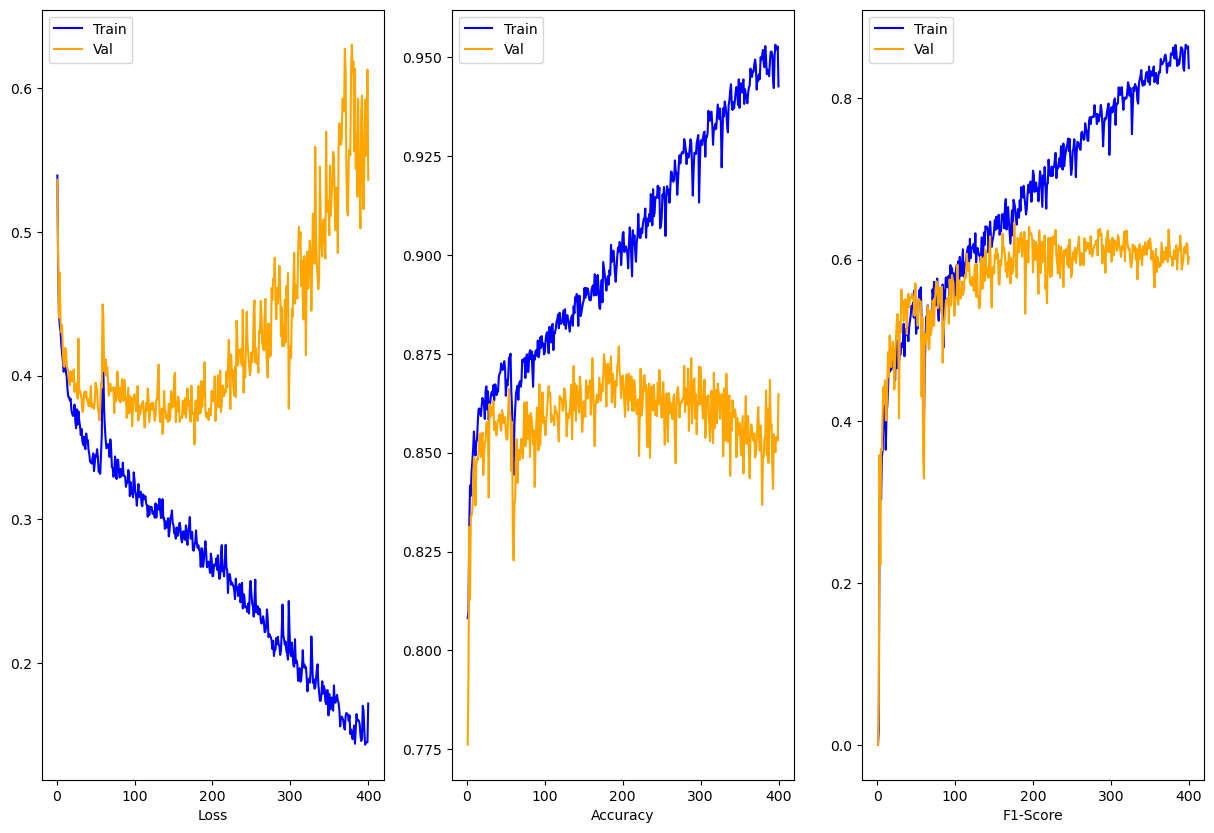

In [11]:
display_metrics(NUM_EPOCHS, metrics)

## Submission

In [12]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    #signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [13]:
# Generate the submission file for Kaggle
model = CombinedModel(output_size=1, window_size=125, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64)
model.to(device)
model.load_state_dict(torch.load("models/lstm_ps_att/best_model.pt"))
# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for x, ids in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.

        # Move the input data to the device (GPU or CPU)
        x = x.to(torch.float32).to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = torch.round(torch.sigmoid(logits)).cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
# submission_df["id"] = submission_df["id"].apply(lambda x: "_".join([txt.replace("_","") for txt in x.split("__")]))
submission_df["label"] = submission_df["label"].astype(int)

submission_df.to_csv("submission_seed1_lstm_ps_att.csv", index=False)
print("Kaggle submission file generated: submission.csv")

/tmp/ipykernel_1858607/4103021174.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/lstm_ps_att/best_model.pt"))


Kaggle submission file generated: submission.csv
